In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer

In [2]:
filename = r"../input/summary-vietnamese/data_summary.csv"
df = pd.read_csv(filename).drop('Unnamed: 0',1)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 102681


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Summary,Text
0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...
3,Người Việt Nam biết rất ít về ông Trump nhưng ...,Tiến sỹ Vũ Cao Phan tin rằng nếu được tiến hàn...
4,Bốn khoa học gia người Mỹ từng đoạt giải Nobel...,GS Jack Steinberger trao đổi với GS Lê Kim Ngọ...


In [3]:
'''Loại bỏ các giá trị trùng lặp và giá trị rỗng'''

df.drop_duplicates(subset=['Text'],inplace=True) #dropping duplicates
df.dropna(axis=0,inplace=True) #dropping na
df = df.reset_index().drop('index', axis = 1)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 96284


,Summary,Text
0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...
3,Người Việt Nam biết rất ít về ông Trump nhưng ...,Tiến sỹ Vũ Cao Phan tin rằng nếu được tiến hàn...
4,Bốn khoa học gia người Mỹ từng đoạt giải Nobel...,GS Jack Steinberger trao đổi với GS Lê Kim Ngọ...


# Data preparation

In [4]:
def cleanWord(s):
    miss = ['!','@','#','$','%','^','&','*','(',')','-','–','_','+','=','{','[','}',']','|',':',';','?','/','<','>','~','`','‘','’',',','()','“','"', '...','”', '“”','\\', '>>', '>>>']
    for i in miss:
        s = s.replace(i,'')
    return re.sub(r'\'', '', s)

def remove_link(string):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', string)

def remove_extra_whitespace(string):
    text = re.sub(r'\s+', ' ', string).strip()
    return text

def lower_word(data):
    return data.lower()

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [alphabet for alphabet in word if alphabet not in string.punctuation]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_number_from_text(text)
    text = rm_punc_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

def solve(string):
    func = [lower_word, remove_link, remove_extra_whitespace, cleanWord, clean_text]
    for i in func:
        string = i(string)
    return string

In [5]:
df.Text = df.Text.apply(lambda x: solve(str(x)))
df.Summary = df.Summary.apply(lambda x: solve(str(x)))
df.head(5)

,Summary,Text
0,ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,tổng thống mỹ donald trump và tổng thống pháp ...
1,rời khỏi việt nam vào ông vũ đình duy tới sống...,vũ đình duy hồi tháng xuất hiện trước tòa tại ...
2,thủ tướng iraq xác nhận với bbc rằng syria khô...,ông maliki xác nhận các vụ không kích của syri...
3,người việt nam biết rất ít về ông trump nhưng ...,tiến sỹ vũ cao phan tin rằng nếu được tiến hàn...
4,bốn khoa học gia người mỹ từng đoạt giải nobel...,gs jack steinberger trao đổi với gs lê kim ngọ...


Finding what should be the **maximum length** of **Text** and **Summary** that will be feed or accepted by the learning algorithm

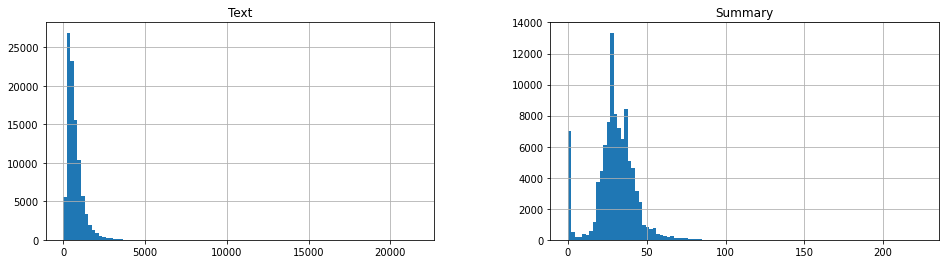

In [6]:
text_count = [len(sentence.split()) for sentence in df.Text]
summary_count = [len(sentence.split()) for sentence in df.Summary]

pd.DataFrame({'Text': text_count, 'Summary': summary_count}).hist(bins=100, figsize=(16, 4))
plt.show()

In [7]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of summary have 0-60 words
print(get_word_percent(df.Summary, 60))

# Check how many % of text have 0-300 words
print(get_word_percent(df.Text, 300))

0.99
0.15


In [8]:
max_text_len = 300
max_summary_len = 60

In [9]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['Text'])
    cleaned_summary = np.array(df['Summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'Text': short_text, 'Summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 14664


,Text,Summary
0,ông maliki xác nhận các vụ không kích của syri...,thủ tướng iraq xác nhận với bbc rằng syria khô...
1,lý quang diệu được cho là người đứng đằng sau...,chính phủ singapore cho hay cựu thủ tướng ngườ...
2,ông hà kim ngọc thứ trưởng bộ ngoại giao phát ...,kết thúc phiên kiểm định định kỳ phổ quát về t...
3,hai bàn thắng của luis suarez hiệp một tạo lợi...,hlv manchester city manuel pellegrini tin rằng...
4,thủ hiến tiểu bang nam úc ông jay weatherill l...,một chính khách gốc việt từng là dân tỵ nạn ...


In [10]:
df.Summary = df.Summary.apply(lambda x: '<start>' + ' '+ x + ' '+ '<end>')

In [11]:
df

,Text,Summary
0,ông maliki xác nhận các vụ không kích của syri...,<start> thủ tướng iraq xác nhận với bbc rằng s...
1,lý quang diệu được cho là người đứng đằng sau...,<start> chính phủ singapore cho hay cựu thủ tư...
2,ông hà kim ngọc thứ trưởng bộ ngoại giao phát ...,<start> kết thúc phiên kiểm định định kỳ phổ q...
3,hai bàn thắng của luis suarez hiệp một tạo lợi...,<start> hlv manchester city manuel pellegrini ...
4,thủ hiến tiểu bang nam úc ông jay weatherill l...,<start> một chính khách gốc việt từng là dân...
...,...,...
14659,cần thơ đẩy nhanh lịch thi học kỳ để chạy dịch...,<start> trước tình hình dịch covid <end>
14660,đây là những học sinh lớp tham gia dự thi kỳ t...,<start> bộ gdđt vừa công bố danh sách học sinh...
14661,cùng dân trí điểm những tin tức đáng chú ngành...,<start> bộ gd <end>
14662,chiều ngày sở gdđt tỉnh bà rịa vũng tàu phát t...,<start> tỉnh bà rịa <end>


In [12]:
text=df.Text
summary=df.Summary

In [13]:
train_t=text[:int(len(text)*0.85)]
test_t=text[int(len(text)*0.85):]
train_s=summary[:int(len(text)*0.85)]
test_s=summary[int(len(text)*0.85):]

In [14]:
tokenizer = Tokenizer(oov_token="<OOV>", filters='')
tokenizer1 = Tokenizer(oov_token="<OOV>", filters='')
tokenizer.fit_on_texts(train_t)
tokenizer1.fit_on_texts(train_s)
word_index = tokenizer.word_index
print(len(word_index))

31081


In [15]:
word_index1 = tokenizer1.word_index
print(len(word_index1))

9919


In [16]:
text_sequences_tr = tokenizer.texts_to_sequences(train_t)
text_padded_tr = pad_sequences(text_sequences_tr,maxlen=300,padding = 'post')

print(text_padded_tr.shape)

(12464, 300)


In [17]:
summary_sequences_tr = tokenizer1.texts_to_sequences(train_s)
summary_padded_tr = pad_sequences(summary_sequences_tr,maxlen=60,padding = 'post')

print(summary_padded_tr.shape)

(12464, 60)


In [18]:
text_sequences_te = tokenizer1.texts_to_sequences(test_t)
text_padded_te = pad_sequences(text_sequences_te,maxlen=300,padding = 'post')

print(text_padded_te.shape)

(2200, 300)


In [19]:
summary_sequences_te = tokenizer.texts_to_sequences(test_s)
summary_padded_te = pad_sequences(summary_sequences_te,maxlen=60,padding = 'post')

print(summary_padded_te.shape)

(2200, 60)


In [20]:
x_train=text_padded_tr
y_train=summary_padded_tr
x_test=text_padded_te
y_test=summary_padded_te

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [22]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 32
steps_per_epoch = len(x_train)//BATCH_SIZE
embedding_dim = 300
units = 128
vocab_inp_size = len(tokenizer.word_index)+1
vocab_tar_size = len(tokenizer1.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-05-15 15:22:11.033527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:22:11.141014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:22:11.141892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:22:11.146506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 300]), TensorShape([32, 60]))

In [24]:
import tensorflow as tf
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

2022-05-15 15:22:14.529952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Encoder output shape: (batch size, sequence length, units) (32, 300, 128)
Encoder Hidden state shape: (batch size, units) (32, 128)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
    
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [27]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 128)
Attention weights shape: (batch_size, sequence_length, 1) (32, 300, 1)


In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
    
        context_vector, attention_weights = self.attention(hidden, enc_output)

    
        x = self.embedding(x)

   
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    
        output, state = self.gru(x)

    
        output = tf.reshape(output, (-1, output.shape[2]))

    
        x = self.fc(output)

        return x, state, attention_weights

In [29]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 9920)


In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer1.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
   
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [33]:
EPOCHS = 10
import time
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2022-05-15 15:23:13.238739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Loss 3.0315
Time taken for 1 epoch 126.69849348068237 sec

Epoch 2 Loss 2.8673
Time taken for 1 epoch 56.49686408042908 sec

Epoch 3 Loss 2.7239
Time taken for 1 epoch 56.35508942604065 sec

Epoch 4 Loss 2.5748
Time taken for 1 epoch 56.56177496910095 sec

Epoch 5 Loss 2.4367
Time taken for 1 epoch 56.099013328552246 sec

Epoch 6 Loss 2.3213
Time taken for 1 epoch 56.57333993911743 sec

Epoch 7 Loss 2.2280
Time taken for 1 epoch 56.108662366867065 sec

Epoch 8 Loss 2.1463
Time taken for 1 epoch 56.81694769859314 sec

Epoch 9 Loss 2.0731
Time taken for 1 epoch 56.21662187576294 sec

Epoch 10 Loss 2.0032
Time taken for 1 epoch 56.66279196739197 sec



In [34]:
def evaluate(sentence):
    #attention_plot = np.zeros((max_length_targ, max_length_inp))

    #sentence = preprocess_sentence(sentence)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=150,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer1.word_index['<start>']], 0)

    for t in range(10):
        predictions, dec_hidden , attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    
        #attention_weights = tf.reshape(attention_weights, (-1, ))
        #attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer1.index_word[predicted_id] + ' '

        if tokenizer1.index_word[predicted_id] == '<end>':
            return result, sentence
        #, attention_plot

    
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [35]:
def translate(sentence):
    result, sentence= evaluate(sentence)
    return result

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [37]:
translate(text[0])

'một người dân chủ tịch quốc gia đình ông nguyễn '

In [38]:
summary[0]

'<start> thủ tướng iraq xác nhận với bbc rằng syria không kích quân nổi dậy isis trên lãnh thổ iraq <end>'

In [39]:
reference = []
hypothesis = []

for i in range(0, 100):
    reference.append(summary[i])
    hypothesis.append(translate(text[i]))

In [40]:
! pip install rouge

In [41]:
from rouge import Rouge

In [42]:
score = Rouge()
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.06138372957884986,
  'p': 0.2940833333333332,
  'f': 0.09782600940095597},
 'rouge-2': {'r': 0.007158214721295215,
  'p': 0.03496428571428571,
  'f': 0.011336435731047074},
 'rouge-l': {'r': 0.057167042943802156,
  'p': 0.27936111111111095,
  'f': 0.09141344153475746}}